# XGBoost
The purpose of this notebook is to use XGBoost for predicting hourly bike demand by station.

In [1]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, accuracy_score, make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn import datasets, svm

## Data Analysis and Exploration

In [2]:
# Import data
df = pd.read_csv('data/bike_temp_clean.csv')
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df.head()

,num_trips,start_datetime,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,...,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month,is_am_peak,is_pm_peak
0,0.0,2019-05-08,3185,0.0,1.0,1.0,0.0,2.0,5.0,6.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
1,1.0,2019-05-08,3638,518.0,4.0,0.0,0.0,4.0,8.0,2.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
2,0.0,2019-05-08,3681,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
3,0.0,2019-05-08,3206,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
4,1.0,2019-05-08,3639,1138.0,0.0,0.0,0.0,0.0,3.0,13.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False


In [ ]:
df.info()

In [6]:
df.corr()

,num_trips,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,...,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month,is_am_peak,is_pm_peak
num_trips,1.000000,-8.651456e-02,0.026238,0.623053,0.412487,0.280602,0.187954,0.126078,0.075991,0.645104,...,-1.095460e-02,-1.382883e-01,-1.350434e-01,1.264729e-02,-2.369475e-02,-2.426448e-03,1.310085e-02,3.067819e-02,1.289355e-01,1.867585e-01
start_station_id,-0.086515,1.000000e+00,-0.008129,-0.086513,-0.086533,-0.086552,-0.086556,-0.086599,-0.086634,-0.087014,...,-4.379510e-15,-5.918962e-16,-2.197016e-16,-1.863306e-15,6.676546e-15,-4.662539e-14,1.731880e-14,1.085718e-13,-9.821399e-17,4.689782e-17
avg_trip_duration,0.026238,-8.128621e-03,1.000000,0.013539,0.014179,0.013591,0.008553,0.005038,0.008570,0.014446,...,1.122812e-03,-2.209293e-02,-1.108456e-02,-7.365955e-03,3.140109e-03,-6.194547e-03,5.173688e-03,-6.137626e-04,-2.142133e-03,1.453659e-02
num_trips_1hr,0.623053,-8.651270e-02,0.013539,1.000000,0.623044,0.412512,0.280734,0.187983,0.125802,0.524449,...,-1.071153e-02,-1.666389e-01,-9.477703e-02,1.289275e-02,-2.244593e-02,-2.432374e-03,1.308366e-02,3.069263e-02,8.853101e-02,1.481493e-01
num_trips_2hr,0.412487,-8.653278e-02,0.014179,0.623044,1.000000,0.623163,0.412760,0.280887,0.187960,0.364094,...,-1.026169e-02,-1.845064e-01,-4.846764e-02,1.254297e-02,-2.120156e-02,-2.330127e-03,1.307567e-02,3.078773e-02,-3.334601e-02,7.564166e-02
num_trips_3hr,0.280602,-8.655248e-02,0.013591,0.412512,0.623163,1.000000,0.623075,0.412556,0.280275,0.256160,...,-1.034247e-02,-1.904579e-01,9.693432e-04,1.172402e-02,-2.108087e-02,-2.376047e-03,1.319408e-02,3.099217e-02,-1.119305e-01,2.083966e-02
num_trips_4hr,0.187954,-8.655564e-02,0.008553,0.280734,0.412760,0.623075,1.000000,0.622783,0.411562,0.174897,...,-1.002687e-02,-1.855824e-01,5.045313e-02,1.060466e-02,-2.200245e-02,-2.377448e-03,1.306356e-02,3.114109e-02,-1.434270e-01,1.079764e-02
num_trips_5hr,0.126078,-8.659940e-02,0.005038,0.187983,0.280887,0.412556,0.622783,1.000000,0.622131,0.122398,...,-8.907878e-03,-1.705455e-01,9.749289e-02,8.081044e-03,-2.451177e-02,-2.119300e-03,1.289841e-02,3.086302e-02,-1.513149e-01,5.952171e-03
num_trips_6hr,0.075991,-8.663401e-02,0.008570,0.125802,0.187960,0.280275,0.411562,0.622131,1.000000,0.080147,...,-5.759783e-03,-1.471379e-01,1.394947e-01,3.841325e-03,-3.008043e-02,-1.818318e-03,1.269827e-02,3.047645e-02,-1.487951e-01,4.244931e-03
num_trips_24hr,0.645104,-8.701449e-02,0.014446,0.524449,0.364094,0.256160,0.174897,0.122398,0.080147,1.000000,...,-6.261705e-03,-1.394011e-01,-1.349887e-01,-1.319319e-03,-2.869935e-02,1.044147e-03,1.245772e-02,2.950819e-02,1.280365e-01,1.883146e-01


In [7]:
df.describe()

,num_trips,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,...,snow_depth,temp_max,temp_min,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month
count,108120.000000,108120.000000,1.081200e+05,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,...,108120.0,108120.000000,108120.000000,1.081200e+05,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000,108120.000000
mean,1.029403,3326.132075,3.791670e+02,1.029403,1.029292,1.029153,1.028811,1.028801,1.029273,1.029652,...,0.0,79.694118,64.611765,-6.545510e-17,0.041667,0.010189,0.135294,-0.054901,-0.063952,6.082353
std,2.432913,188.388673,8.127193e+03,2.432898,2.432888,2.432591,2.431369,2.430834,2.435043,2.435279,...,0.0,9.138228,8.349881,6.922219e-01,0.720487,0.657460,0.741180,0.708103,0.701067,0.800177
min,0.000000,3183.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,48.000000,42.000000,-9.976688e-01,-0.990686,-0.866025,-1.000000,-0.998717,-0.994869,5.000000
25%,0.000000,3201.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,73.000000,59.000000,-6.560249e-01,-0.626438,-0.866025,-0.500000,-0.724793,-0.758758,5.000000
50%,0.000000,3225.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,81.000000,66.000000,-1.224647e-16,0.067607,0.000000,0.500000,-0.101168,-0.050649,6.000000
75%,1.000000,3281.000000,3.440000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,87.000000,71.000000,6.560249e-01,0.725520,0.866025,1.000000,0.651372,0.688967,7.000000
max,70.000000,3792.000000,1.729020e+06,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,...,0.0,95.000000,82.000000,9.976688e-01,1.000000,0.866025,1.000000,0.998717,1.000000,7.000000


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


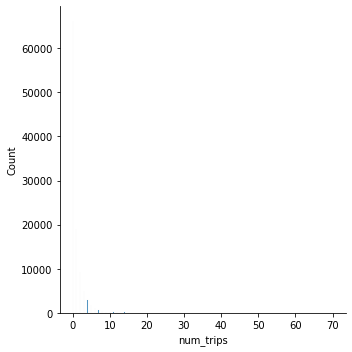

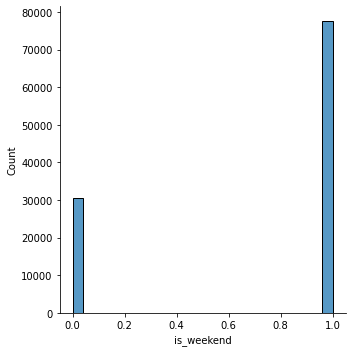

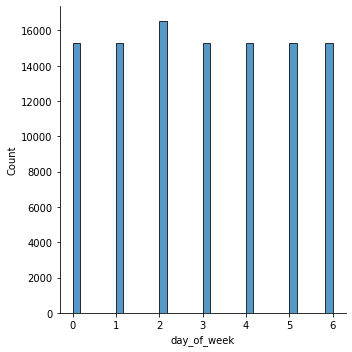

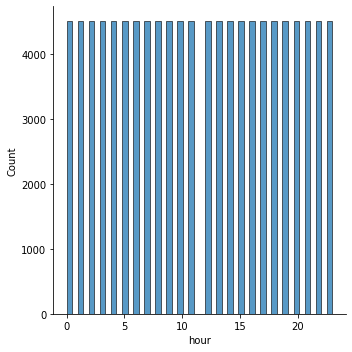

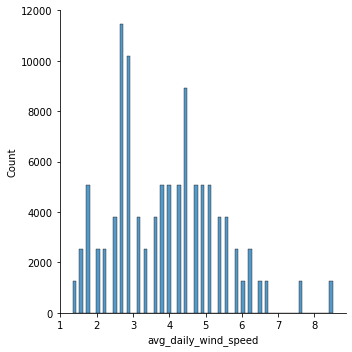

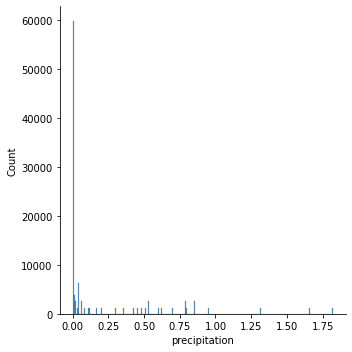

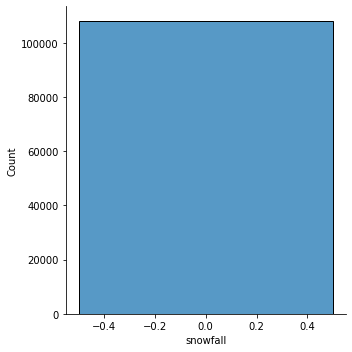

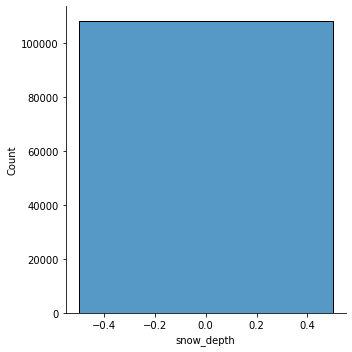

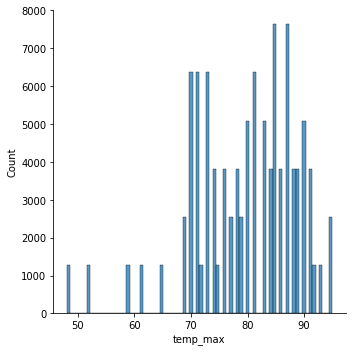

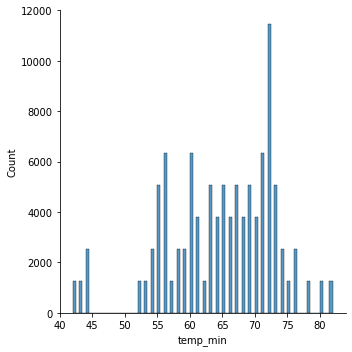

In [8]:
# Plot distribution of num_trips, is_weekend, day_of_week, and hour
sns.displot(df['num_trips'])
sns.displot(df['is_weekend'])
sns.displot(df['day_of_week'])
sns.displot(df['hour'])
sns.displot(df['avg_daily_wind_speed'])
sns.displot(df['precipitation'])
sns.displot(df['snowfall'])
sns.displot(df['snow_depth'])
sns.displot(df['temp_max'])
sns.displot(df['temp_min'])

Note that num_trips does not look like a Gaussian distribution, so lets transform to a logarithmic distribution.

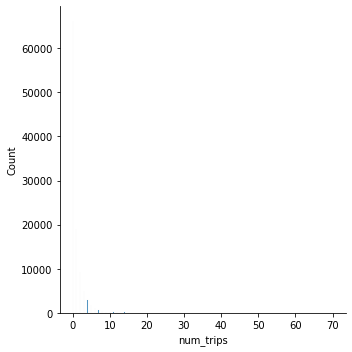

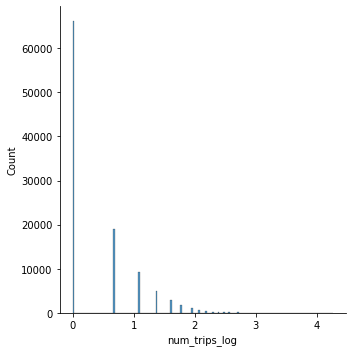

In [3]:
df['num_trips_log'] = np.log1p(df['num_trips'])
#df = df.reindex(columns=['num_trips', 'num_trips_log', 'start_datetime', 'start_station_id', 'avg_trip_duration', 'is_weekend', 'day_of_week', 'hour'])
sns.displot(df['num_trips'])
sns.displot(df['num_trips_log'])

num_trips_log does not appear any more Gaussian than num_trips, so lets delete

In [4]:
df.drop(columns=['num_trips_log'], inplace=True)

Now lets plot the num_trips over time

<AxesSubplot:xlabel='start_datetime'>

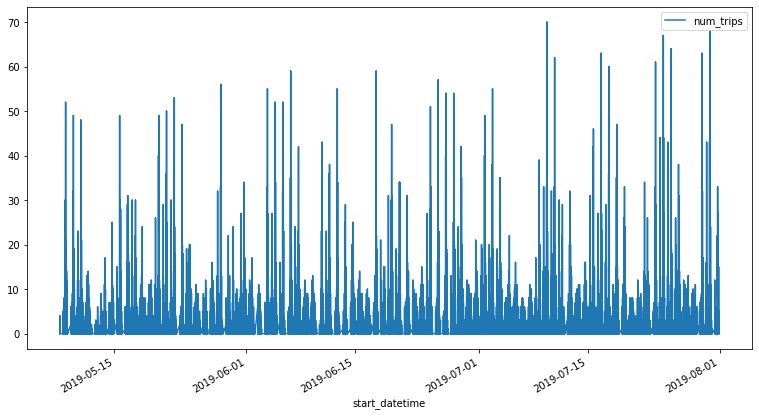

In [9]:
df.plot(x='start_datetime', y='num_trips', figsize=(13,7))

The number of trips appear to increase over the course of the month.

<AxesSubplot:xlabel='hour', ylabel='num_trips'>

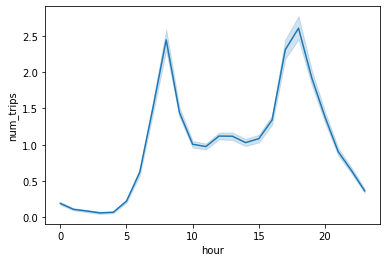

In [10]:
sns.lineplot(data=df, x='hour', y='num_trips')

The distribution of num_trips by hour appears to have two peaks in the AM and PM peak hours

<AxesSubplot:xlabel='start_datetime'>

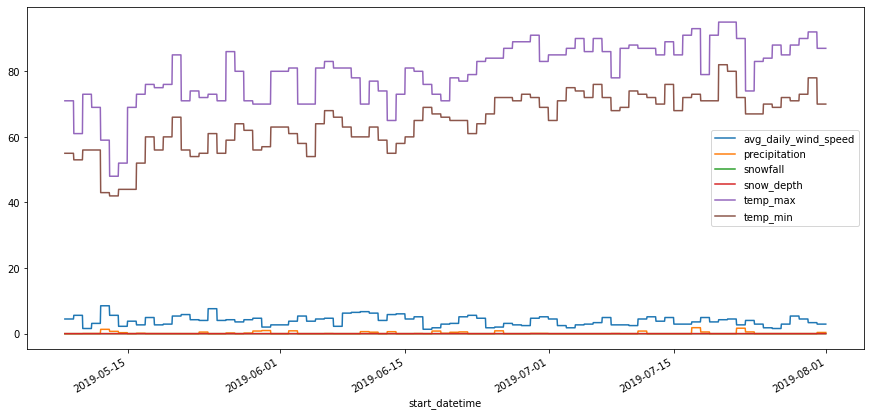

In [11]:
df.plot(x='start_datetime', y=['avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth', 'temp_max', 'temp_min'], figsize=(15,7))

In [12]:
df.columns

Index(['num_trips', 'start_datetime', 'start_station_id', 'avg_trip_duration',
       'num_trips_1hr', 'num_trips_2hr', 'num_trips_3hr', 'num_trips_4hr',
       'num_trips_5hr', 'num_trips_6hr', 'num_trips_24hr', 'num_trips_48hr',
       'num_trips_week', 'day_of_week', 'is_weekend', 'hour',
       'avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth',
       'temp_max', 'temp_min', 'fog', 'heavy_fog', 'thunder', 'haze'],
      dtype='object')

<AxesSubplot:>

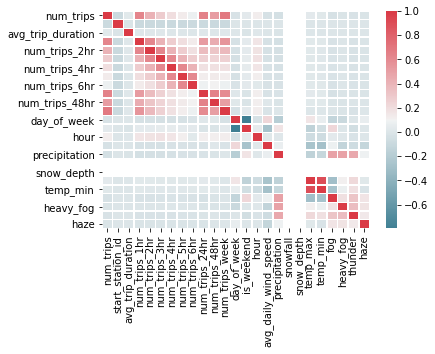

In [13]:
# Plot heatmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), cmap=cmap, linewidths=0.5)

Note that is_weekend and day_of_week are correlated and temp_min and temp_max are correlated. We should likely choose just one of them, but we will test this out with the XGBoost model and importance scores.

## Feature Engineering

Because hour and day_of_week is a cyclical feature, we will encode it using cosine and sine

In [5]:
# Encode time series with cyclical features
df['hour_sin'] = np.sin((2 * np.pi * df['hour']) / max(df['hour']))
df['hour_cos'] = np.cos((2 * np.pi * df['hour']) / max(df['hour']))
df['day_of_week_sin'] = np.sin((2 * np.pi * df['day_of_week']) / max(df['day_of_week']))
df['day_of_week_cos'] = np.cos((2 * np.pi * df['day_of_week']) / max(df['day_of_week']))
df.head()

,num_trips,start_datetime,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,...,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month,is_am_peak,is_pm_peak
0,0.0,2019-05-08,3185,0.0,1.0,1.0,0.0,2.0,5.0,6.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
1,1.0,2019-05-08,3638,518.0,4.0,0.0,0.0,4.0,8.0,2.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
2,0.0,2019-05-08,3681,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
3,0.0,2019-05-08,3206,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
4,1.0,2019-05-08,3639,1138.0,0.0,0.0,0.0,0.0,3.0,13.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False


In [6]:
# Extract month and day from start_datetime
df['month'] = df['start_datetime'].dt.month
df

,num_trips,start_datetime,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,...,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month,is_am_peak,is_pm_peak
0,0.0,2019-05-08 00:00:00,3185,0.0,1.0,1.0,0.0,2.0,5.0,6.0,...,False,0.000000e+00,1.0,0.866025,-0.5,9.987165e-01,-0.050649,5,False,False
1,1.0,2019-05-08 00:00:00,3638,518.0,4.0,0.0,0.0,4.0,8.0,2.0,...,False,0.000000e+00,1.0,0.866025,-0.5,9.987165e-01,-0.050649,5,False,False
2,0.0,2019-05-08 00:00:00,3681,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,False,0.000000e+00,1.0,0.866025,-0.5,9.987165e-01,-0.050649,5,False,False
3,0.0,2019-05-08 00:00:00,3206,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,False,0.000000e+00,1.0,0.866025,-0.5,9.987165e-01,-0.050649,5,False,False
4,1.0,2019-05-08 00:00:00,3639,1138.0,0.0,0.0,0.0,0.0,3.0,13.0,...,False,0.000000e+00,1.0,0.866025,-0.5,9.987165e-01,-0.050649,5,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108115,0.0,2019-07-31 23:00:00,3201,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,-2.449294e-16,1.0,0.866025,-0.5,-2.449294e-16,1.000000,7,False,False
108116,0.0,2019-07-31 23:00:00,3198,0.0,0.0,1.0,2.0,1.0,0.0,0.0,...,False,-2.449294e-16,1.0,0.866025,-0.5,-2.449294e-16,1.000000,7,False,False
108117,0.0,2019-07-31 23:00:00,3426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,-2.449294e-16,1.0,0.866025,-0.5,-2.449294e-16,1.000000,7,False,False
108118,0.0,2019-07-31 23:00:00,3791,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,False,-2.449294e-16,1.0,0.866025,-0.5,-2.449294e-16,1.000000,7,False,False


In [7]:
# Now drop the start_datetime column as we no longer need it
df.drop(columns=['start_datetime'], inplace=True)

We previously noticed that bike demand was significant during the AM and PM peak hour times, lets add features for that. 

In [8]:
# Add day/night hours
df['is_am_peak'] = (df['hour']>=7) & (df['hour']<=9)
df['is_pm_peak'] = (df['hour']>=16) & (df['hour']<=19)
df.head()

,num_trips,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,...,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month,is_am_peak,is_pm_peak
0,0.0,3185,0.0,1.0,1.0,0.0,2.0,5.0,6.0,1.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
1,1.0,3638,518.0,4.0,0.0,0.0,4.0,8.0,2.0,0.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
2,0.0,3681,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
3,0.0,3206,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False
4,1.0,3639,1138.0,0.0,0.0,0.0,0.0,3.0,13.0,0.0,...,False,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,5,False,False


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92008 entries, 0 to 92007
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num_trips             92008 non-null  float64
 1   start_station_id      92008 non-null  int64  
 2   avg_trip_duration     92008 non-null  float64
 3   num_trips_1hr         92008 non-null  float64
 4   num_trips_2hr         92008 non-null  float64
 5   num_trips_3hr         92008 non-null  float64
 6   num_trips_4hr         92008 non-null  float64
 7   num_trips_5hr         92008 non-null  float64
 8   num_trips_6hr         92008 non-null  float64
 9   num_trips_24hr        92008 non-null  float64
 10  num_trips_48hr        92008 non-null  float64
 11  num_trips_week        92008 non-null  float64
 12  day_of_week           92008 non-null  int64  
 13  is_weekend            92008 non-null  bool   
 14  hour                  92008 non-null  int64  
 15  avg_daily_wind_spee

## Train XGBoost Model

### Testing Train/Test Sizes

In [9]:
# Split data into X, y, and y_log
X = df.iloc[0:,1:]
y = df.iloc[:,0:1]

Because we are predicting bike demand in the future, we want to train data in the past and test data in the future. Let's test the model with different splits

In [36]:
# Create model
model = xgb.XGBRegressor()

# Test model for different splits
# The test sizes represent approximately 1 week, 2 weeks, and 3 weeks
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for test_size in test_sizes:
    print(f"TEST SIZE: {test_size}", )
    # Test/train for that split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    # For non-scaled counts
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE for predicting counts: %f" % (rmse))

TEST SIZE: 0.1
RMSE for predicting counts: 1.435607
TEST SIZE: 0.2
RMSE for predicting counts: 1.327153
TEST SIZE: 0.3
RMSE for predicting counts: 1.358166
TEST SIZE: 0.4
RMSE for predicting counts: 1.349458
TEST SIZE: 0.5
RMSE for predicting counts: 1.376008
TEST SIZE: 0.6
RMSE for predicting counts: 1.345830
TEST SIZE: 0.7
RMSE for predicting counts: 1.561387
TEST SIZE: 0.8
RMSE for predicting counts: 1.458407
TEST SIZE: 0.9
RMSE for predicting counts: 1.509402


It appears the best training/test split is 80/20, as that results in the lowest RMSE.

### Feature Selection

Test features to use in the non-transformed counts model

In [20]:
model = xgb.XGBRegressor()
best_split = 0.2

# Counts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    # select features above threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    # evaluate model
    select_X_test = selection.transform(X_test)
    preds = selection_model.predict(select_X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("Thresh=%.3f, n=%d, RMSE: %lf" % (thresh, select_X_train.shape[1], rmse))

# Transformed Count
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)

Thresh=0.000, n=34, RMSE: 1.349628
Thresh=0.000, n=34, RMSE: 1.349628
Thresh=0.000, n=34, RMSE: 1.349628
Thresh=0.000, n=34, RMSE: 1.349628
Thresh=0.006, n=30, RMSE: 1.349628
Thresh=0.007, n=29, RMSE: 1.353159
Thresh=0.008, n=28, RMSE: 1.360910
Thresh=0.009, n=27, RMSE: 1.344163
Thresh=0.009, n=26, RMSE: 1.341077
Thresh=0.010, n=25, RMSE: 1.357814
Thresh=0.010, n=24, RMSE: 1.340259
Thresh=0.010, n=23, RMSE: 1.353616
Thresh=0.010, n=22, RMSE: 1.330518
Thresh=0.013, n=21, RMSE: 1.325215
Thresh=0.013, n=20, RMSE: 1.336326
Thresh=0.014, n=19, RMSE: 1.342301
Thresh=0.014, n=18, RMSE: 1.348109
Thresh=0.015, n=17, RMSE: 1.358783
Thresh=0.016, n=16, RMSE: 1.366885
Thresh=0.016, n=15, RMSE: 1.365421
Thresh=0.017, n=14, RMSE: 1.365450
Thresh=0.017, n=13, RMSE: 1.345330
Thresh=0.017, n=12, RMSE: 1.351668
Thresh=0.019, n=11, RMSE: 1.365022
Thresh=0.020, n=10, RMSE: 1.373374
Thresh=0.021, n=9, RMSE: 1.374710
Thresh=0.023, n=8, RMSE: 1.366715
Thresh=0.032, n=7, RMSE: 1.358528
Thresh=0.035, n=6, RMSE

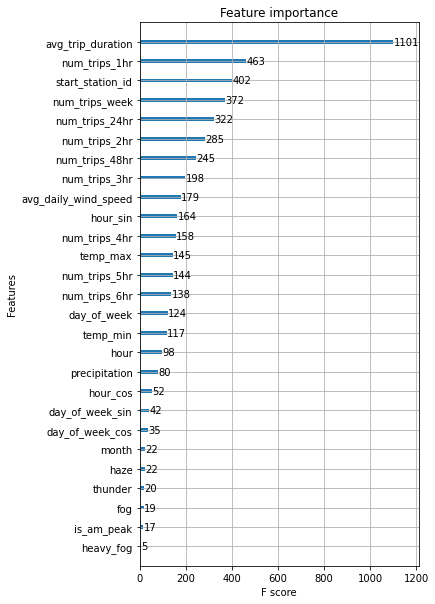

In [39]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(5, 10)

heavy_fog, is_am_peak, is_pm_peak, fog, thunder, and haze appear to increase RMSE. Thus, lets remove them from the model

In [8]:
df.drop(columns=['heavy_fog', 'is_am_peak', 'is_pm_peak', 'fog', 'thunder', 'haze'], inplace=True)
df.head()

,num_trips,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,...,precipitation,snowfall,snow_depth,temp_max,temp_min,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month
0,0.0,3185,0.0,1.0,1.0,0.0,2.0,5.0,6.0,1.0,...,0.0,0.0,0.0,71,55,0.0,1.0,0.866025,-0.5,5
1,1.0,3638,518.0,4.0,0.0,0.0,4.0,8.0,2.0,0.0,...,0.0,0.0,0.0,71,55,0.0,1.0,0.866025,-0.5,5
2,0.0,3681,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,71,55,0.0,1.0,0.866025,-0.5,5
3,0.0,3206,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,71,55,0.0,1.0,0.866025,-0.5,5
4,1.0,3639,1138.0,0.0,0.0,0.0,0.0,3.0,13.0,0.0,...,0.0,0.0,0.0,71,55,0.0,1.0,0.866025,-0.5,5


In [9]:
# Split data into X and y
best_split = 0.2
X = df.iloc[0:,1:]
y = df.iloc[:,0:1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)

### Hyperparameter Tuning

In [14]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [15]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [30]:
def mean_absolute_percentage_error(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    return np.mean(np.abs((actual - predict) / actual)) * 100

#### max_depth, min_child_weight

In [48]:
# Train max_depth and min_child_weight
# These parameters add constraints on the architectures of the trees, and should be trained together
xgbGridCV = xgb.XGBRegressor()

# max_depth: max number of nodes allowed from root to leaf
# Too large a depth can overfit
# min_child_weight: minimum weight required to create a new node in the tree
# smaller values allow for children to be created with fewer samples
parameters = {
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 3, 5, 7],
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 3, 'min_child_weight': 3}

-1.247 (+/-0.078) for {'max_depth': 3, 'min_child_weight': 1}
-1.233 (+/-0.058) for {'max_depth': 3, 'min_child_weight': 3}
-1.238 (+/-0.069) for {'max_depth': 3, 'min_child_weight': 5}
-1.253 (+/-0.075) for {'max_depth': 3, 'min_child_weight': 7}
-1.265 (+/-0.085) for {'max_depth': 6, 'min_child_weight': 1}
-1.252 (+/-0.126) for {'max_depth': 6, 'min_child_weight': 3}
-1.253 (+/-0.083) for {'max_depth': 6, 'min_child_weight': 5}
-1.248 (+/-0.109) for {'max_depth': 6, 'min_child_weight': 7}
-1.288 (+/-0.084) for {'max_depth': 9, 'min_child_weight': 1}
-1.276 (+/-0.097) for {'max_depth': 9, 'min_child_weight': 3}
-1.279 (+/-0.086) for {'max_depth': 9, 'min_child_weight': 5}
-1.279 (+/-0.064) for {'max_depth': 9, 'min_child_weight': 7}


In [49]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of preds, y_test: {rmse}")

RMSE of preds, y_test: 1.3341515062306348


#### n_estimators, learning_rate

In [50]:
# Now train n_estimators and learning_rate together

# learning_rate
# weighting factor for the corrections by new trees when adding to the model
# values < 1 has effect of making less corrections for each tree added to the model
# this in turn results in more trees that must be added to the model

# n_estimators
# the number of decision trees

parameters = {
    'max_depth': [3],
    'min_child_weight': [3],
    'n_estimators' : [10, 25, 50, 100, 200, 400, 500],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}

-2.495 (+/-0.267) for {'learning_rate': 0.0001, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 10}
-2.493 (+/-0.267) for {'learning_rate': 0.0001, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 25}
-2.49 (+/-0.267) for {'learning_rate': 0.0001, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50}
-2.482 (+/-0.266) for {'learning_rate': 0.0001, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
-2.468 (+/-0.265) for {'learning_rate': 0.0001, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}
-2.439 (+/-0.262) for {'learning_rate': 0.0001, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 400}
-2.425 (+/-0.26) for {'learning_rate': 0.0001, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}
-2.482 (+/-0.266) for {'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 10}
-2.461 (+/-0.264) for {'learning_rate': 0.001,

In [51]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of preds, y_test: {rmse}")

RMSE of preds, y_test: 1.3262828337782324


#### subsample

In [19]:
# Now train subsample - 
# these control the sampling of the dataset that is done at each boosting round
# They make it less likely to overfit to a single sample or feature
# subsample - fraction of observations to subsample at each step
xgbGridCV = xgb.XGBRegressor()
parameters = {
    'max_depth': [3],
    'min_child_weight': [3],
    'n_estimators' : [500],
    'learning_rate' : [0.2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 1.0}

-1.263 (+/-0.071) for {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.5}
-1.251 (+/-0.056) for {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.6}
-1.237 (+/-0.071) for {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.7}
-1.23 (+/-0.073) for {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.8}
-1.232 (+/-0.057) for {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9}
-1.228 (+/-0.057) for {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 1.0}


In [16]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of preds, y_test: {rmse}")

RMSE of preds, y_test: 1.3578002511654284


Using a subsample of 0.9 actually increases the RMSE, thus lets not include in the model.

#### colsample_bytree

In [23]:
# Now train colsample_bytree - 
# these control the sampling of the dataset that is done at each boosting round
# They make it less likely to overfit to a single sample or feature
# colsample_bytree - fraction of features (the columns) to use

xgbGridCV = xgb.XGBRegressor()
parameters = {
    'max_depth': [3],
    'min_child_weight': [3],
    'n_estimators' : [500],
    'learning_rate' : [0.2],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}

-1.217 (+/-0.058) for {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}
-1.227 (+/-0.066) for {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}
-1.225 (+/-0.059) for {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}
-1.222 (+/-0.065) for {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}
-1.232 (+/-0.058) for {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}
-1.228 (+/-0.057) for {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}


In [24]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of preds, y_test: {rmse}")

RMSE of preds, y_test: 1.3166392053893017


#### Final Model

In [21]:
# Now lets run the model with only the best parameters
xgbGridCV = xgb.XGBRegressor()
parameters = {
    'max_depth': [3],
    'min_child_weight': [3],
    'n_estimators' : [500],
    'learning_rate' : [0.2],
    'colsample_bytree': [0.5]
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=5, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}

-1.192 (+/-0.106) for {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}


## Results

### Error (RMSE, MAE, MAPE)

In [41]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
# Make any negative predictions 0
preds[preds < 0] = 0

# Determine RMSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
R2 = r2_score(y_test, preds)
print(f"RMSE of preds, y_test: {rmse}")
print(f"MAE of preds, y_test: {mae}")
print(f"R-Squared of preds, y_test: {R2}")

RMSE of preds, y_test: 1.285520493341562
MAE of preds, y_test: 0.5099513601352038
R-Squared of preds, y_test: 0.7811175923739538


### Plot Actual vs. Predicted

In [72]:
# Combine X_test, y_test, preds
combined_df = pd.concat([X_test, y_test], axis=1)
combined_df['preds'] = preds
combined_df.head()

,start_station_id,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,num_trips_48hr,...,snow_depth,temp_max,temp_min,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month,num_trips,preds
73606,3483,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,...,0.0,91,72,0.269797,0.962917,0.866025,0.5,7,0.0,0.000000
73607,3679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,91,72,0.269797,0.962917,0.866025,0.5,7,0.0,0.000000
73608,3211,0.0,1.0,0.0,0.0,2.0,0.0,8.0,1.0,0.0,...,0.0,91,72,0.269797,0.962917,0.866025,0.5,7,0.0,0.000000
73609,3220,0.0,0.0,0.0,1.0,0.0,3.0,5.0,0.0,0.0,...,0.0,91,72,0.269797,0.962917,0.866025,0.5,7,0.0,0.000000
73610,3273,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,91,72,0.269797,0.962917,0.866025,0.5,7,0.0,0.021146


In [15]:
# Find max station, median station
sum_trips_df = df.groupby(['start_station_id'])['num_trips'].sum()

min_trips = sum_trips_df.min()
first_quart_trips = sum_trips_df.quantile(0.25, interpolation='nearest')
median_trips = sum_trips_df.median()
third_quart_trips = sum_trips_df.quantile(0.75, interpolation='nearest')
max_trips = sum_trips_df.max()


min_station = sum_trips_df[sum_trips_df == min_trips].index[0]
first_quart_station = sum_trips_df[sum_trips_df == first_quart_trips].index[0]
median_station = sum_trips_df[sum_trips_df == median_trips].index[0]
third_quart_station = sum_trips_df[sum_trips_df == third_quart_trips].index[0]
max_station = sum_trips_df[sum_trips_df == max_trips].index[0]

In [22]:
print("Station: trips")
print(f"{min_station}: {min_trips}")
print(f"{first_quart_station}: {first_quart_trips}")
print(f"{median_station}: {median_trips}")
print(f"{third_quart_station}: {third_quart_trips}")
print(f"{max_station}: {max_trips}")

Station: trips
3426: 13.0
3268: 855.0
3194: 1685.0
3187: 2750.0
3186: 12477.0


In [74]:
# Get max/median station values
max_station_df = combined_df.loc[df['start_station_id'] == max_station]
median_station_df = combined_df.loc[df['start_station_id'] == median_station]

In [75]:
# Join max/median station with original df to get original datetimes
bike_df = pd.read_csv('data/bike_temp_clean.csv')
median_station_df = median_station_df.merge(bike_df)
max_station_df = max_station_df.merge(bike_df)

<AxesSubplot:xlabel='start_datetime'>

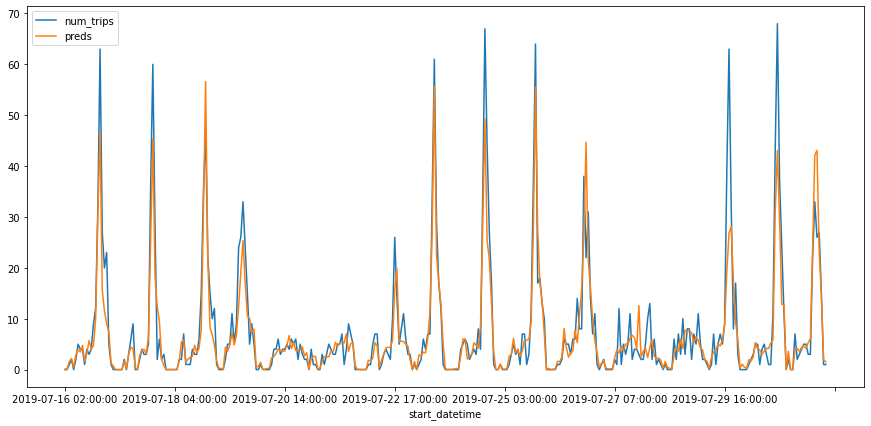

In [76]:
# Plot of max_station
max_station_df.plot(x='start_datetime', y=['num_trips', 'preds'], figsize=(15,7))

<AxesSubplot:xlabel='start_datetime'>

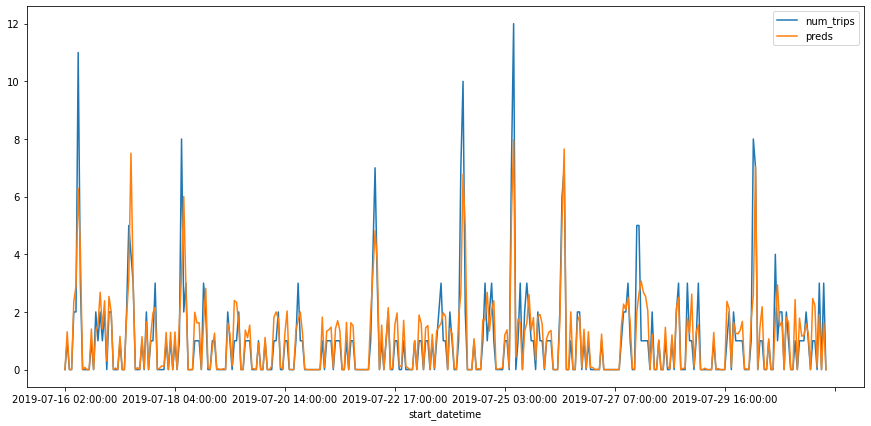

In [77]:
# Plot of median_station
median_station_df.plot(x='start_datetime', y=['num_trips', 'preds'], figsize=(15,7))

### Plot Distribution of Hourly Demand

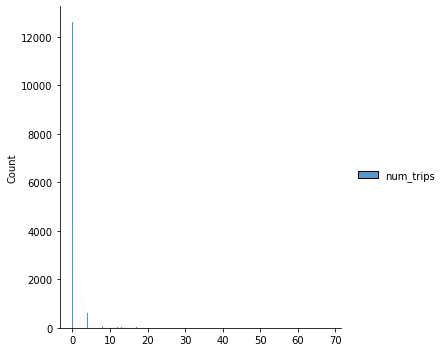

In [49]:
# Actual
#plt.plot(np.histogram(y_test))
sns.displot(y_test)

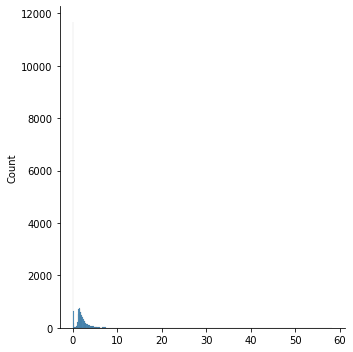

In [50]:
# Predicted
sns.displot(preds)